In [1]:
%%capture
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot([0,1],[1,0])
from neuronunit.optimisation import make_sim_tests
import numpy as np
from IPython.display import display, HTML
from neuronunit.plottools import plot_score_history1
from neuronunit.optimisation.optimization_management import check_binary_match
import pandas as pd


# Simulated Data 
and select model parameters that are free to vary

In [2]:
%%capture
fps = ['c','a','b']
model_type="RAW"
sim_tests, OM, target = make_sim_tests.test_all_objective_test(fps,model_type=model_type)

# Meta Parameters

In [3]:
MU = 10 
NGEN = 50

In [4]:
results = sim_tests.optimize(backend=model_type,\
        protocol={'allen': False, 'elephant': True},\
            MU=MU,NGEN=NGEN,plot=True,free_parameters=fps)



GA Generation Progress: 100%|██████████| 49/49 [23:27<00:00, 28.72s/it]


# Analyse Results

In [5]:
opt = results['pf'][0].dtc
hof = results['hof'][0].dtc
OM.tests = opt.tests
opt = OM.format_test(opt)
opt.self_evaluate()
opt = OM.get_agreement(opt)
display(opt.agreement)

,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,91.00799560546875 pA,3.1953703924275967 ms,-65.2261863636364 mV,40370197.69232159 kg*m**2/(s**3*A**2),7.915171525244613e-11 s**4*A**2/(kg*m**2),0.00517 s,0.5295266858334671 mV,-58.408802991252024 mV,NaN
predictions,91.17536544799805 pA,3.189905546985477 ms,-65.2261863636364 mV,40332797.953932695 kg*m**2/(s**3*A**2),7.908961710588297e-11 s**4*A**2/(kg*m**2),0.005200000000000001 s,0.5139670166565153 mV,-58.352658766152736 mV,NaN
scores,0.000783762,0.000682519,0,0.000384454,0.000313037,0.00231763,0.0117914,0.000383548,0.045141


In [ ]:
# This should be more succint than above.
agreement = opt.get_agreement().agreement

# Look at evolution History

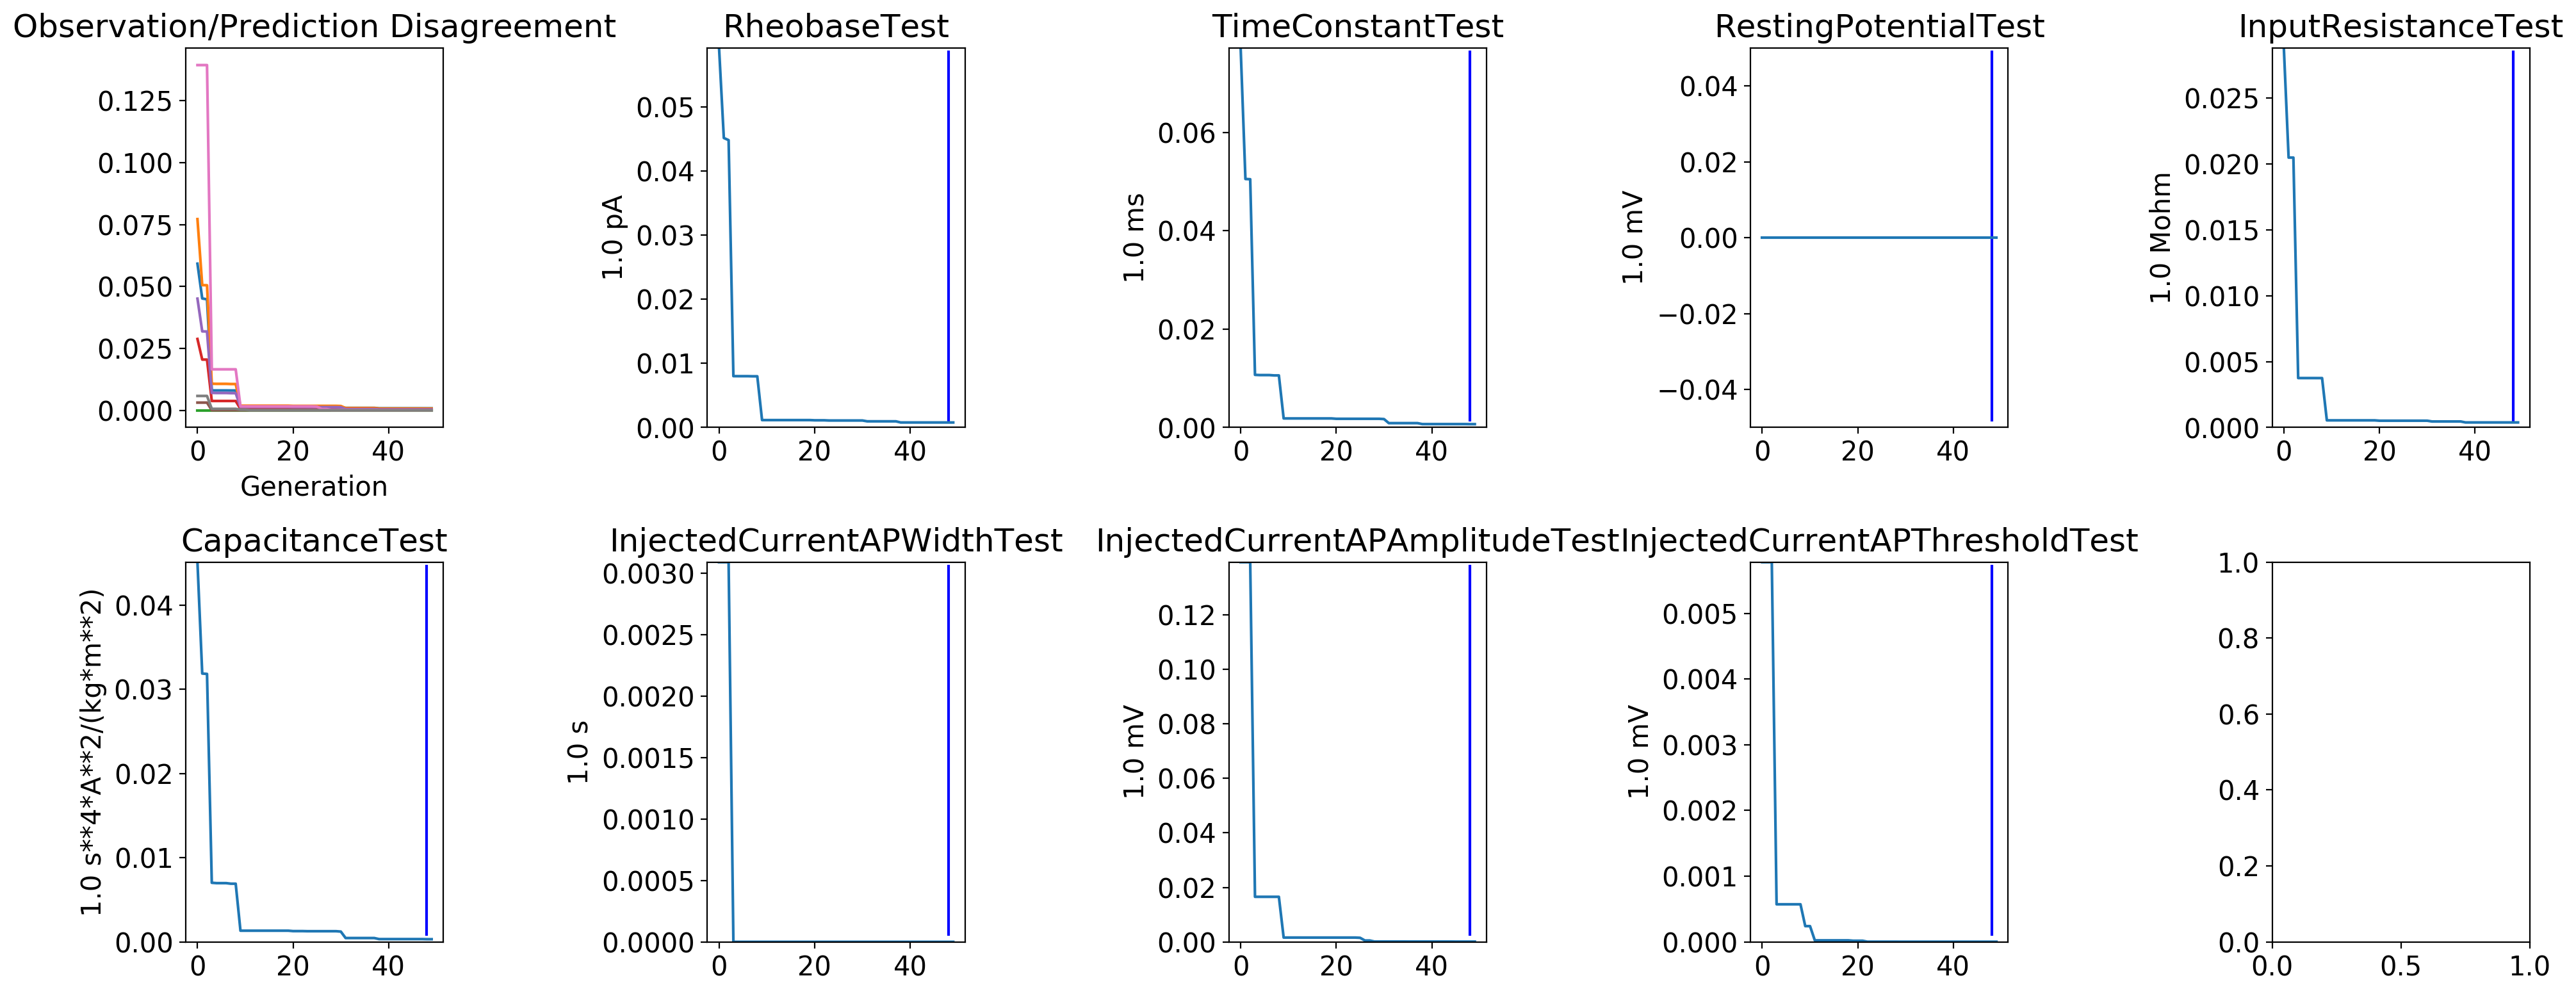

In [6]:
plt = plot_score_history1(results)
from neuronunit.optimisation.optimization_management import check_binary_match

<Figure size 640x480 with 0 Axes>

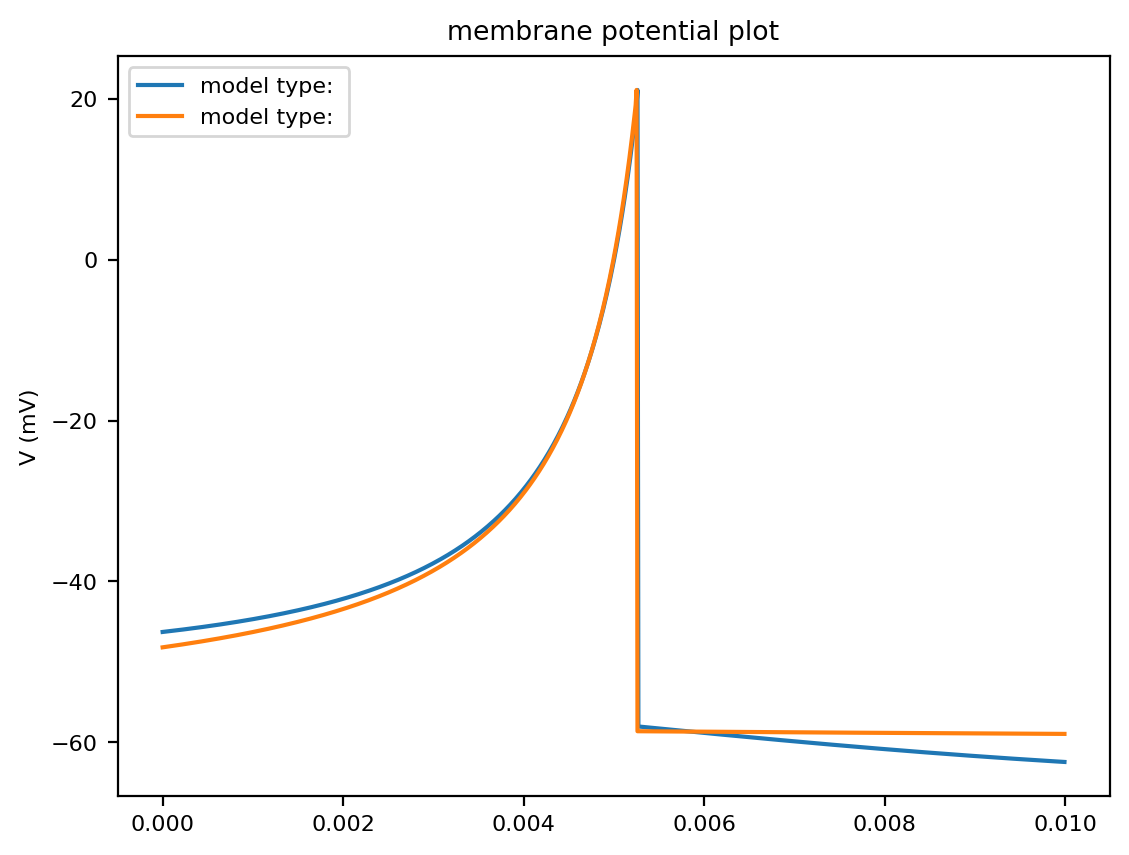

In [7]:
model = target.dtc_to_model()
check_binary_match(opt,target,snippets=True)
target = OM.format_test(target)
simulated_data_tests = target.tests

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

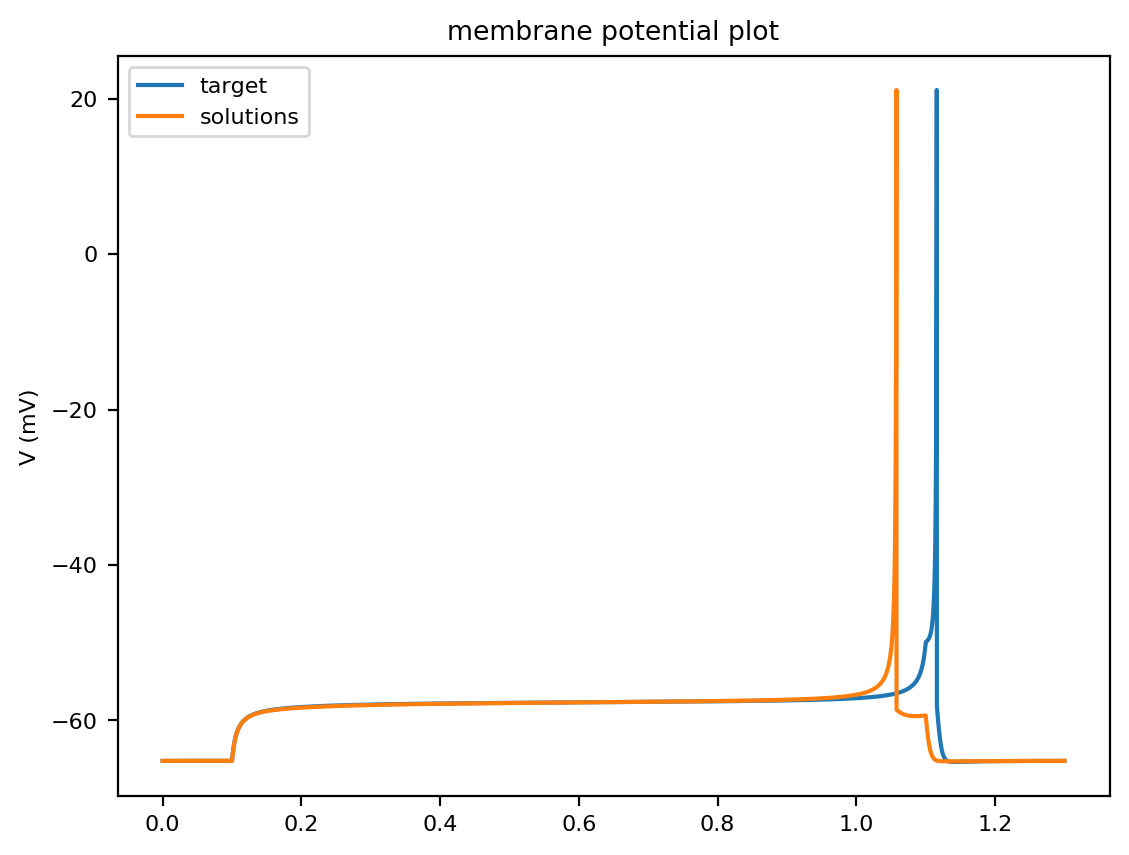

In [8]:
check_binary_match(opt,target,snippets=False)

In [9]:
try:
    opt.attrs.pop('dt',None)
    opt.attrs.pop('Iext',None)
except:
    pass


In [10]:
display(pd.DataFrame([opt.attrs]))
import copy
temp = {}
for k in opt.attrs.keys():
    temp[k] = target.attrs[k]
display(pd.DataFrame([temp]))

,a,b,c
0,0.027791,-0.213585,-58.039239


,a,b,c
0,0.018971,-0.238156,-58.630064


In [11]:
display(pd.DataFrame([{k.name:v for k,v in opt.SA.items()}]))

,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest
0,0.000784,0.000683,0.0,0.000384,0.000313,0.002318,0.011791,0.000384


What where the values of model parameters that where held constant?


In [12]:
df0 = opt.dtc_to_model().default_attrs
df1 = target.dtc_to_model().default_attrs
hc = {}

try:
    df0.attrs.pop('dt',None)
    df0.attrs.pop('Iext',None)
    opt.attrs.pop('dt',None)
    opt.attrs.pop('Iext',None)

except:
    pass

for k,v in df0.items():
    if k not in opt.attrs.keys():
        assert df0[k] == df1[k]
        hc[k] = v        
display("Held constant:")
display(pd.DataFrame([hc]))        

'Held constant:'

,C,d,k,vPeak,vr,vt,dt,Iext
0,89.796071,10,1.6,21.138339,-65.226186,-50,0.01,[]


If the Pareto Front encircles the best solution without sampling directly on top of it.
Does piercing the center get us closer to the hall of fame?
Below, plot HOF[0]/PF[0] are they the same model? 

In [13]:
# check_binary_match(opt,hof,snippets=True)


# Exploring the neighbourhood of 
the Optimal solution is now syntatically easy

## Make ranges to explore:

In [42]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
a_range = MODEL_PARAMS["RAW"]['a']
grid_a = np.linspace(a_range[0],a_range[1],10)
b_range = MODEL_PARAMS["RAW"]['b']
grid_b = np.linspace(b_range[0],b_range[1],10);

def find_nearest(array, value):
    """
    What if 10 points is too coarse and we miss a minima well?
    We can insert the known optima back into a sequence of grid points just in case
    
    """
    #value = float(value)
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (array[idx], idx)



## Mutate a parameter in a dimension of interest.

In [15]:
opt_sum = np.sum(opt.SA.values)
for_scatter = (opt.attrs['a'],opt_sum)
from tqdm import tqdm
collect = []
mutant = copy.copy(opt)
for a in tqdm(grid_a):
    # non random mutation
    mutant.attrs['a'] = a
    # Evaluate NU test suite
    mutant.self_evaluate()
    # sum components (optional)
    fit = np.sum(mutant.SA.values)
    collect.append(fit)

100%|██████████| 10/10 [01:13<00:00,  7.35s/it]


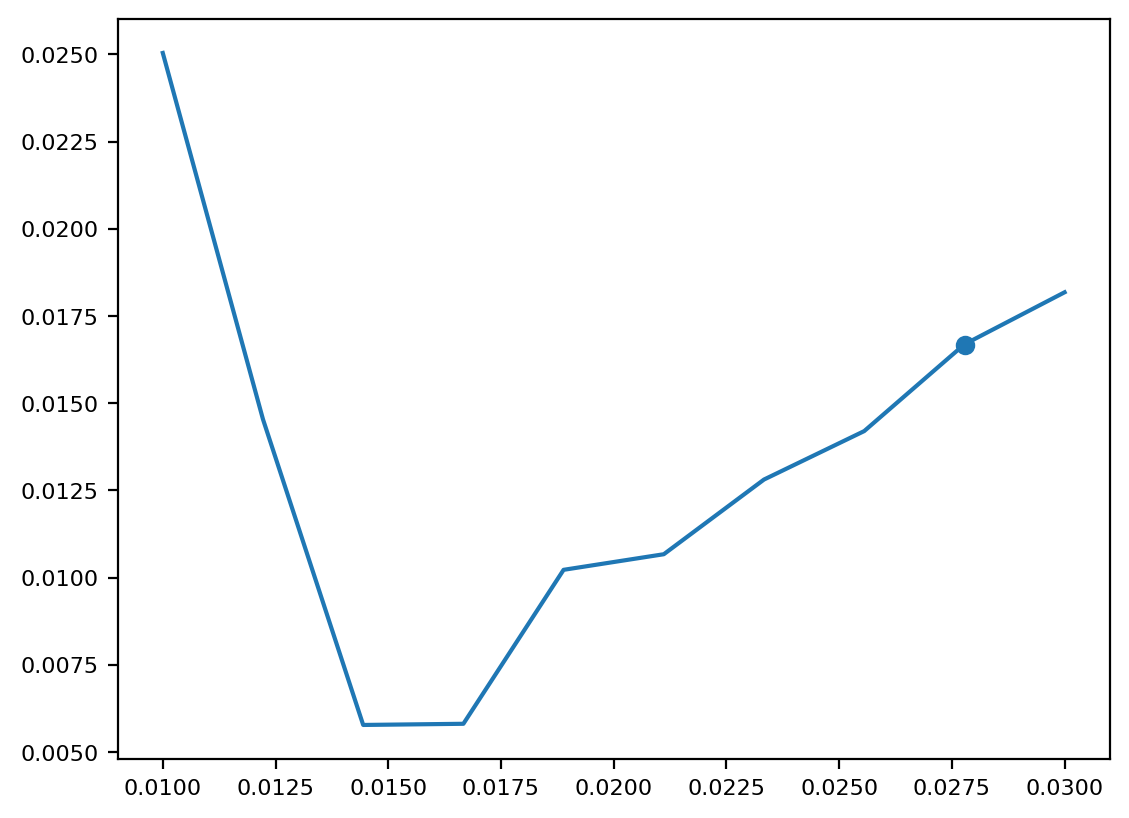

In [16]:
plt.plot(grid_a,collect)
plt.scatter(for_scatter[0],for_scatter[1],label='optima')


The above plot seemed to have two steep wells, of low error about the optima.

It might not be reasonable to expect to sample every such well, as the stochastic nature of the GA is not garunteed to sample small and and focused pockets of error change.

In [39]:
opt_sum = np.sum(opt.SA.values)
for_scatter = (opt.attrs['b'],opt_sum)
from tqdm import tqdm
collect = []
mutant = copy.copy(opt)

insert_index = find_nearest(grid_b,opt.attrs['b'])[1]
grid_b = list(grid_b)
grid_b.insert(insert_index,opt.attrs['b'])
for b in tqdm(grid_b):
    # non random mutation
    mutant.attrs['b'] = b
    # Evaluate NU test suite
    mutant.self_evaluate()
    # sum components (optional)
    fit = np.sum(mutant.SA.values)
    collect.append(fit)


100%|██████████| 11/11 [00:24<00:00,  2.27s/it]


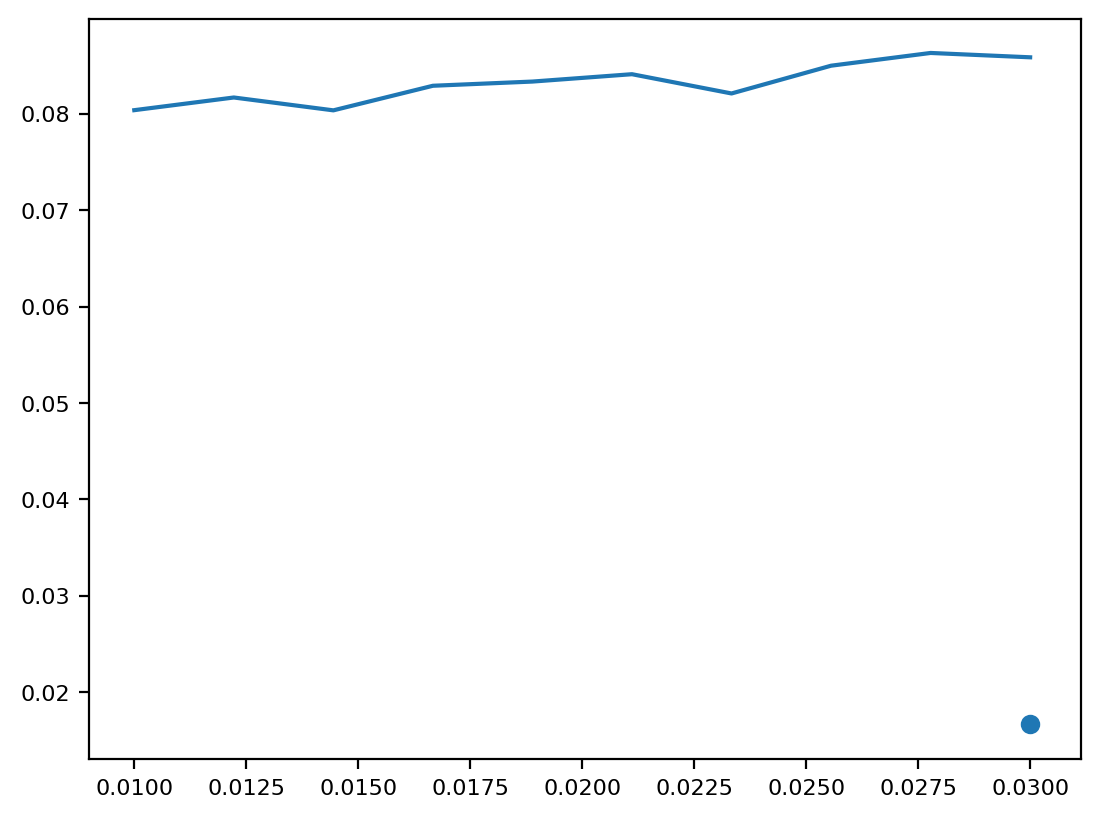

In [21]:
plt.plot(grid_b,collect)
for_scatter = (opt.attrs['b'],opt_sum)
plt.scatter(for_scatter[0],for_scatter[1],label='optima')


In [44]:
insert_index = find_nearest(grid_b,opt.attrs['b'])
print(insert_index[1])

(15.0, 9)
